# Implementing Upper Confident Bound For MovieLens 100k Datasaet


### Initialization python envirnment


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import math


### Loading the data and define train and test data

In [2]:
item_file = 'ml-100k/u.item'
user_file = 'ml-100k/u.user'
rating_file = 'ml-100k/u.data'


item_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
] + [f'genre_{i}' for i in range(19)]  # 19 genres

rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

items = pd.read_csv(item_file, sep='|', encoding='latin-1', names=item_cols, header=None)
users = pd.read_csv(user_file, sep='|', names=user_cols, header=None)

ratings = pd.read_csv(rating_file, sep='\t', names=rating_cols, header=None)

#  sorting ratings by timestamp before splitting to simulate chronological learning:
ratings = ratings.sort_values(by='timestamp')

X = ratings.drop('rating', axis=1)
y = ratings['rating']

ix = int(len(ratings) * 0.8)
train = ratings.iloc[0:ix,:]
test = ratings.iloc[ix:,:]

### Define Arms to be Movie Ids

In [3]:
n_arms = len(ratings['movie_id'].unique()) #1682
unique_arms = ratings['movie_id'].unique()


# Upper Confidence Bound Class

Action Selection:
$$A_t = \arg\max_a \big[Q_t(a) + c \sqrt{\frac{\ln(t)}{N_t(a)}}\big]$$

In [4]:
# UpperConfidenceBound class
class UpperConfidenceBound:
    def __init__(self, arms, c):
        self.arms = arms  # list of movie_ids
        self.c = c
        self.time = 0
        self.Q = {arm: 0.0 for arm in arms}  # optimistic init arm:1
        self.N = {arm: 0 for arm in arms}

    def select_arm(self):
        self.time += 1
        max_q_value = -float('inf')
        selected_arm = None
        
        for arm_id, cur_q_value in self.Q.items():
            if self.N[arm_id] == 0:
                ucb_value = float('inf')
            else:
                ucb_value = cur_q_value + self.c * math.sqrt(math.log(self.time)/self.N[arm_id])
                
            if ucb_value > max_q_value:
                max_q_value = ucb_value
                selected_arm = arm_id
            
        return selected_arm

    def update(self, chosen_arm, reward):
        self.N[chosen_arm] += 1
        n = self.N[chosen_arm]
        self.Q[chosen_arm] += (1 / n) * (reward - self.Q[chosen_arm])

    def average_q(self):
        return statistics.mean(self.Q.values())

### Online Training
We simulate online interactions

In [5]:

c = 0.1
ucb = UpperConfidenceBound(unique_arms, c)


total_interactions = 0
total_rewards = 0

num_interactions_per_user = 3  # <--- we can change this number

unique_users = train['user_id'].unique()

for user_id in unique_users:
    for _ in range(num_interactions_per_user):
        chosen_movie = ucb.select_arm()
        # Check if this user rated the chosen movie
        row = train[(train['user_id'] == user_id) & (train['movie_id'] == chosen_movie)]
        
        
        reward = 0
        if len(row) > 0:
            #If a user rated the same movie multiple times (which is rare but possible in some systems),
            #you might want to take the most recent rating (or average).
            rating = row.sort_values(by='timestamp', ascending=False).iloc[0]['rating']

            #OR
            #rating = row.iloc[0]['rating']
            
            reward = int(rating >= 4)
            
            
        ucb.update(chosen_movie, reward)
        total_rewards += reward
        total_interactions += 1
    
print(f"Total Interactions: {total_interactions}")
print(f"Total Reward (ratings ≥ 4): {total_rewards}")
print(f"Average Reward: {total_rewards / total_interactions:.4f}")

Total Interactions: 2253
Total Reward (ratings ≥ 4): 217
Average Reward: 0.0963


# Evaluation
Compute precision@k

In [6]:
def is_recommended(row):
    if (row['rating']>=4):
        return 1
    else:
        return 0


k = 5
precision_k = 0
unique_users = test['user_id'].unique()
user_count = len(unique_users)
Q_sorted = sorted(ucb.Q.items(), key = lambda x:x[1], reverse = True)

#If we decide to use only top k movies
selected_movies = [item[0] for item in Q_sorted[:k]]



for user in unique_users:
    
    filtered_test = test.loc[(test['user_id'] == user) & (test['movie_id'].isin(selected_movies))].copy()
    if len(filtered_test)>0:
        filtered_test['result'] = filtered_test.apply(is_recommended, axis = 1)
        count = filtered_test['result'].sum()
        precision_k += (count/k)
precision_k = precision_k/user_count
print(precision_k)
    
    
    

0.11561461794019919


### Average cumulative rewards with simulation

the order of users matters in online training, even when users are fixed, because these algorithms (epsilon-greedy and UCB) learn incrementally. Early interactions shape the policy's decisions for later interactions — this creates **ordering bias**. The first few users strongly influence which arms look best (because exploration is limited).

If early users rate certain movies highly, the algorithm may prematurely favor those arms (even if they're not globally best). Say your training data has these users at the top: Users who happen to rate *movie A* highly, then Epsilon-greedy or UCB will quickly favor *movie A*. Later users who might prefer other movies won't influence the policy much (especially in UCB, where exploration reduces over time).

But if you reshuffle and put diverse users earlier, the policy might Explore other arms earlier, Learn a better estimate of global preferences.

Both Epsilon-Greedy and UCB are **sequential decision-making algorithms**. They learn over time. At any given "step" (which, in your simulation, corresponds to interacting with a user), the algorithm makes a choice based on its current knowledge (the Q-values, N counts, and global time step t). After making a choice and receiving a reward, it updates this knowledge. The next decision will then be made based on this updated knowledge

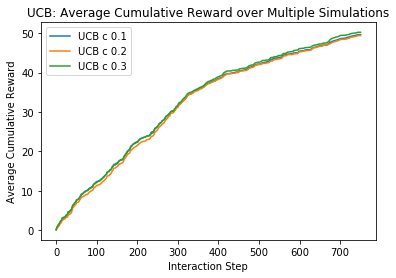

In [18]:
c_values = [0.1,0.2,0.3]

num_simulations = 100

for c in c_values:
    
    all_runs = [] # stores cumulative rewards from each simulation
    
    for sim in range(num_simulations):
     
        ucb = UpperConfidenceBound(unique_arms, c)

        total_interactions = 0
        total_rewards = 0

        num_interactions_per_user = 1  # <--- you can change this number

        # To ensure diverse simulations, shuffle users in each run
        unique_users = np.random.permutation(train['user_id'].unique())

#         unique_users = train['user_id'].unique()

        cum_reward =[]
        cur_step = 0

        for user_id in unique_users:
            for _ in range(num_interactions_per_user):
                chosen_movie = ucb.select_arm()
                # Check if this user rated the chosen movie
                row = train[(train['user_id'] == user_id) & (train['movie_id'] == chosen_movie)]

                reward = 0 ## DEFAULT: Assume 0 reward if the user didn't rate the chosen movie
                if len(row) > 0:
                    rating = row.iloc[0]['rating']
                    reward = int(rating >= 4)
                    
                ucb.update(chosen_movie, reward)
                total_rewards += reward
                total_interactions += 1

                cum_reward.append(total_rewards)
                
        all_runs.append(cum_reward)

            
    ave_cum_reward = np.mean(all_runs, axis=0)        
    plt.plot(ave_cum_reward, label=f'UCB c {c}')

plt.title('UCB: Average Cumulative Reward over Multiple Simulations')
plt.xlabel('Interaction Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
plt.show()
